# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/Src/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/Src/integration")

# add TRA folder to current working path
sys.path.append(parent_directory+"/Demos/AdvectiveBarriers/TRA")

CPU times: user 687 µs, sys: 573 µs, total: 1.26 ms
Wall time: 725 µs


In [2]:
# Suppress numba warnings arising from computation falling back into object mode.
from numba.core.errors import NumbaDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

# Overview

In the following notebok we visualize elliptic LCS in the Agulhas region from the AVISO dataset by means of the lagrangian single trajectory rotation diagnostics TRA (= Trajectory Rotation Angle). The notebook is structured as follows:

* Import data from the file 'Agulhas_AVISO.mat' stored in the folder 'Data'
* Define computational parameters (such as the number of cores to be used for parallel computing) and variables
* Define spatio-temporal domain over which to compute the hyperbolic LCS. The spatial domain defines the meshgrid from where to launch the trajectories and the temporal domain specifies the time-interval (in days).
* Interpolate velocity from the gridded velocity data using cubic spline interpolation.
* Compute trajectories and velocity along trajectories over meshgrid of initial conditions over the specified time-interval
* Compute TRA for each trajectory.

# AVISO Data from Agulhas Region

In [3]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../Data/Aviso/processed_data/Agulhas_AVISO.mat')

U = mat_file['u'][:,:,::7]
V = mat_file['v'][:,:,::7]
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t'][:,::7]

CPU times: user 34.4 ms, sys: 21 ms, total: 55.4 ms
Wall time: 54.3 ms


# Data/Parameters for Dynamical System

In [13]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 32

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-Temporal Domain of Dynamical System

In [5]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# time step-size (in days)
dt = .1

time = np.arange(t0, tN+dt, dt)

# length of time interval (in days)
lenT = tN-t0

# longitudinal and latitudinal boundaries (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -24

# spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

CPU times: user 1.1 ms, sys: 1.35 ms, total: 2.45 ms
Wall time: 1.11 ms


# Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant. 

In [6]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time, method = "cubic")

CPU times: user 97.2 ms, sys: 30.2 ms, total: 127 ms
Wall time: 127 ms


# Trajectory Rotation Average ($ \mathrm{\overline{TRA}}$)

In [7]:
%%time
# Import package for computing trajectories/velocity
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import package for TRA
from ipynb.fs.defs.TRA import _TRA

# set v0 is set equal to the average velocity in the Agulhas region
v0 = np.mean(np.sqrt(U.ravel()**2+V.ravel()**2))

def parallel_TRA(i):
    
    TRA_parallel = X_domain[0,:].copy()*np.nan
    
    for j in range(X_domain.shape[1]):
        
        # set initial condition
        x = np.array([X_domain[i, j], Y_domain[i, j]])
    
        # compute trajectory/velocity
        Fmap, dFdt = integration_dFdt(time, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta)
        
        TRA_parallel[j] = _TRA(lenT, dFdt, v0)
        
    return TRA_parallel

TRA = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_TRA)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/401 [00:00<?, ?it/s]

CPU times: user 7.33 s, sys: 2.09 s, total: 9.42 s
Wall time: 3min 30s


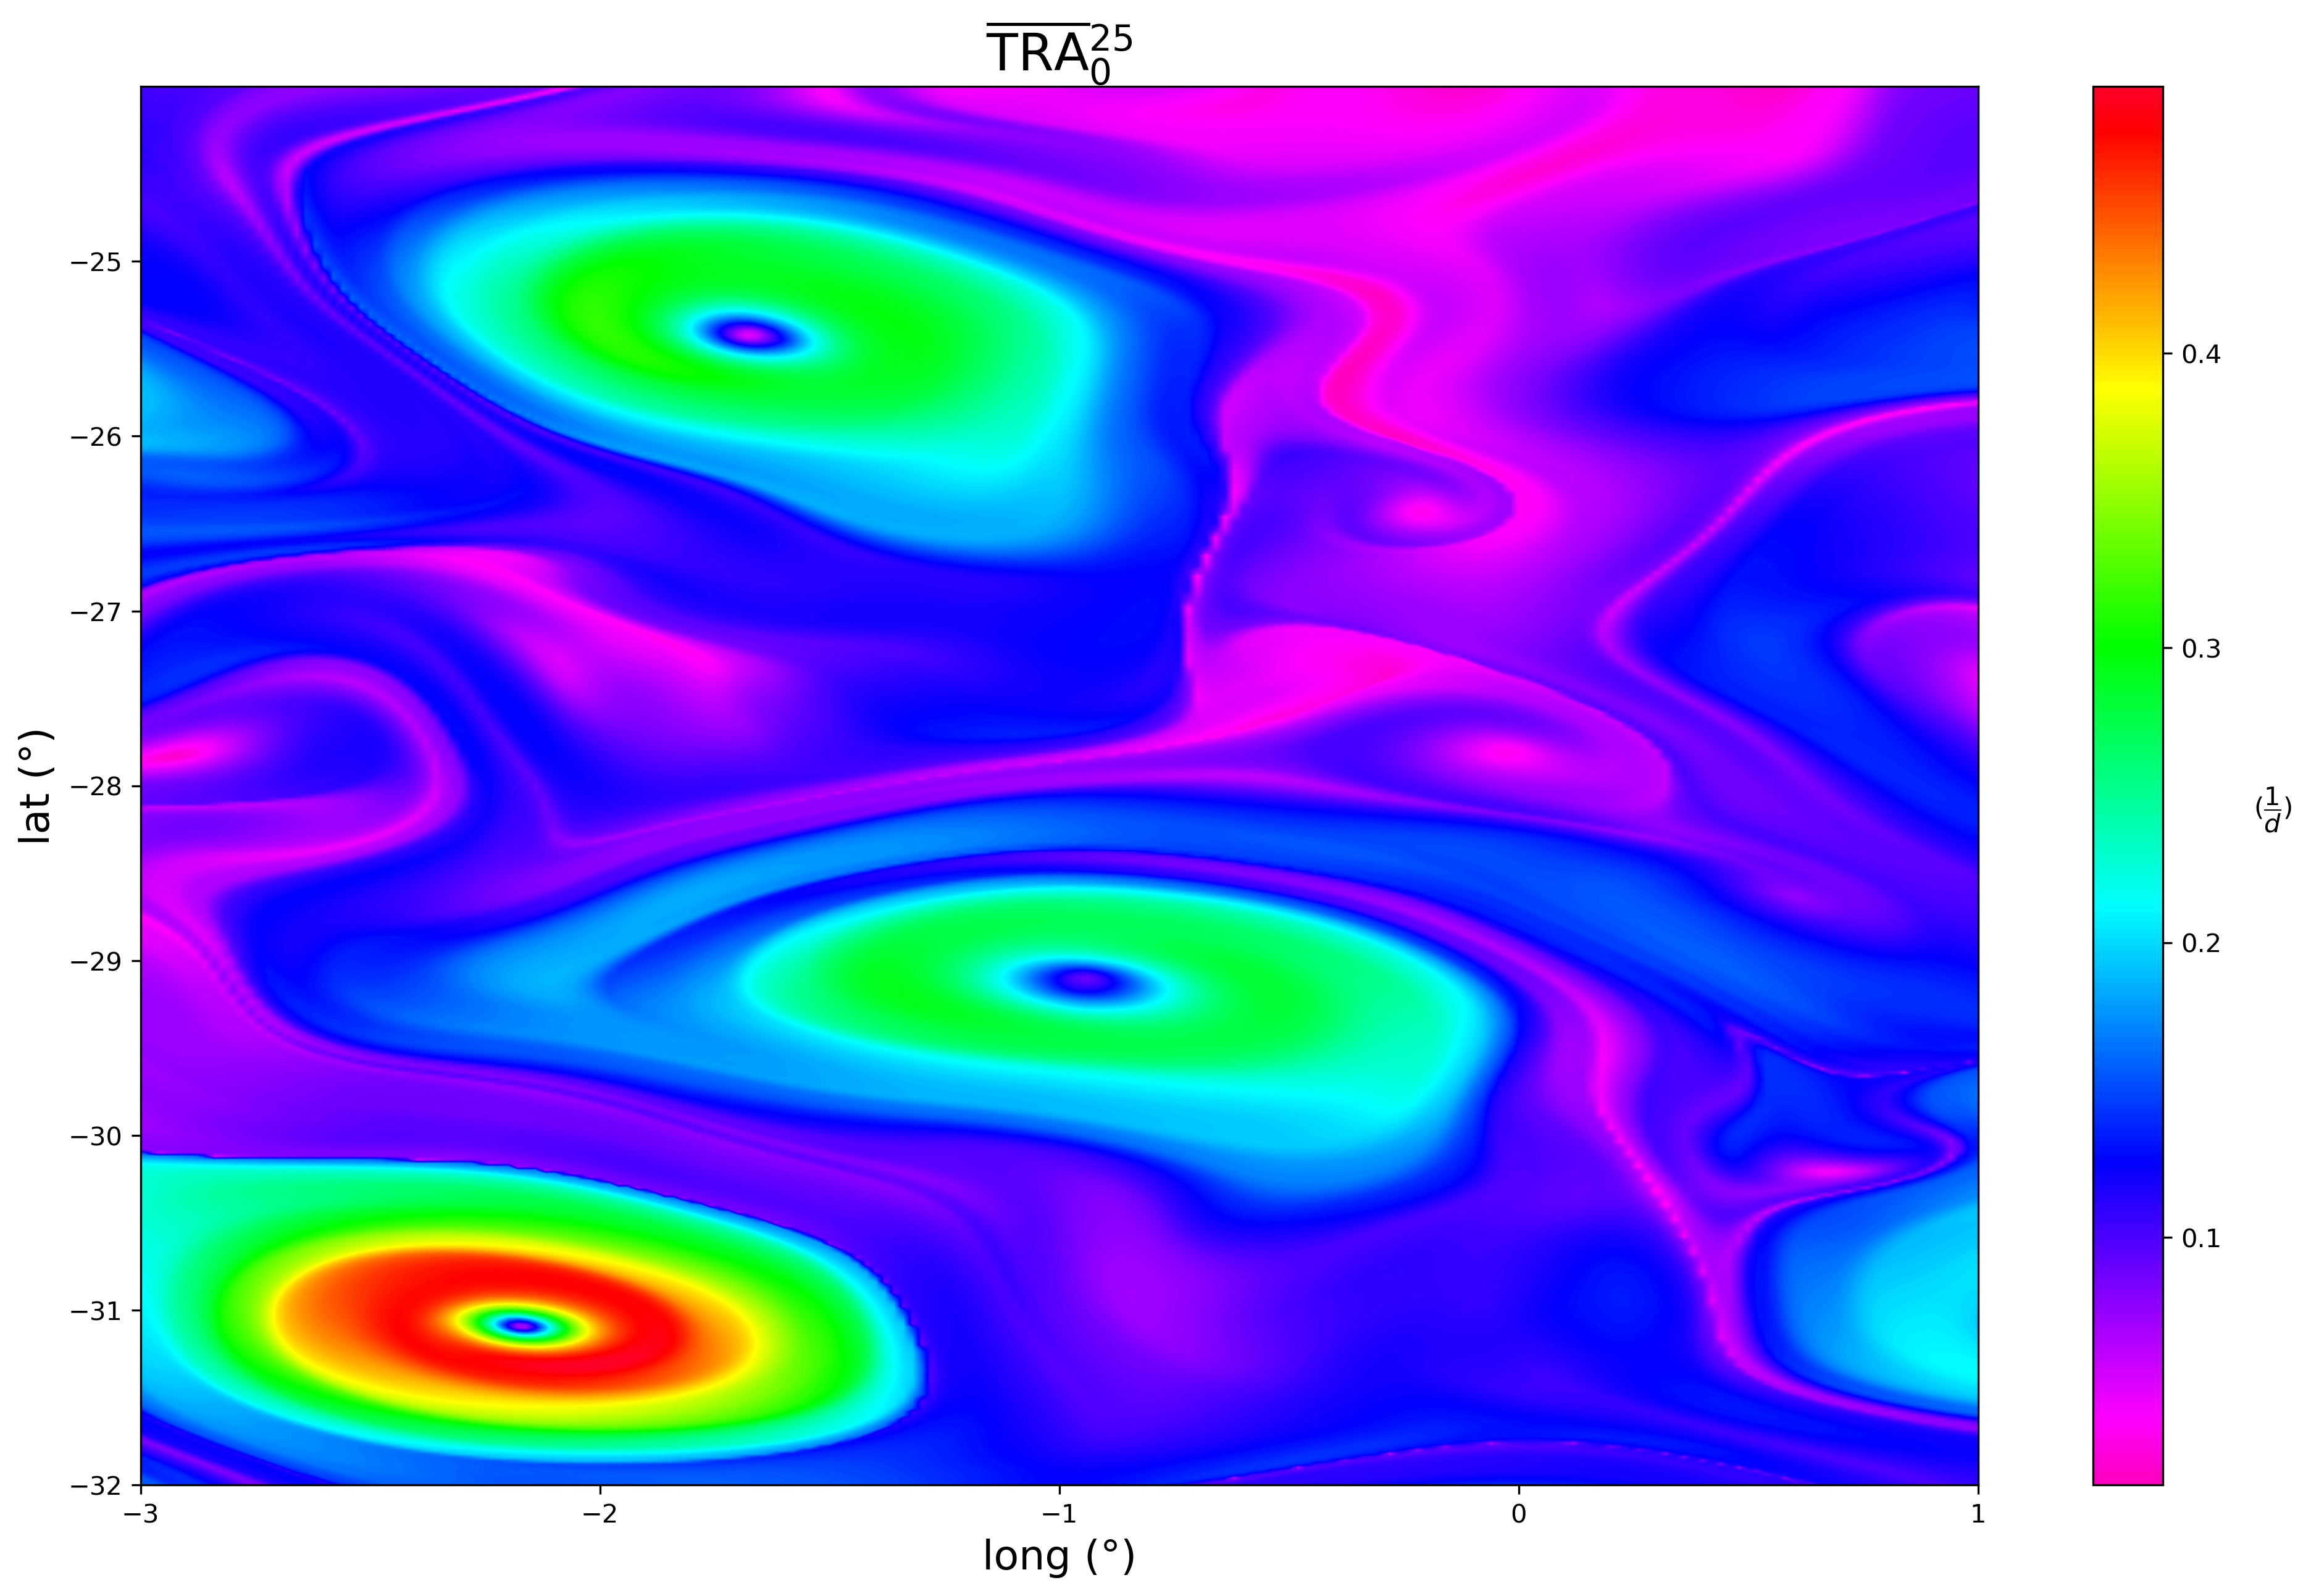

In [12]:
######################## PLOT RESULTS ########################
import matplotlib.pyplot as plt

# Figure/Axis
fig = plt.figure(figsize=(16, 10), dpi = 300)
ax = plt.axes()

# Contourplot of TSE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, TRA, cmap = "gist_rainbow_r", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 16)
ax.set_ylabel("lat (°)", fontsize = 16)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, .7, 8))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, labelpad = 20, fontsize = 10)

# Title
ax.set_title(r'$ \mathrm{\overline{TRA}}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$', fontsize = 20)

plt.show()